# Assignment 9
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### In This assignment we are going to introduce to gradCAM where we are going to see where are model focuses while looking at an image

### So we have two objective in this assignment:
*   To introduce to gradCAM to old Assignment 6A code
*   To introduce cutout augmentation technique and then again apply gradCAM on top of that

### So to achieve this goal lets first import keras library and  import all pakages and functions from keras with which we are going to build the CNN model

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
import cv2
from google.colab.patches import cv2_imshow

Using TensorFlow backend.


### Now we are going to load the pre-shuffled CIFAR10 data from keras. Out of total 60k data we have 50k different class image as train data and 10k image as test data which is autometically predefined in mnist dataset. So here we have total 10 different classes of images as: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.

In [7]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols, img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))
print(train_features.shape)
print(test_features.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


### Now let's look into some images. Here we are going to pick one image from each class randomly to see how it looks:

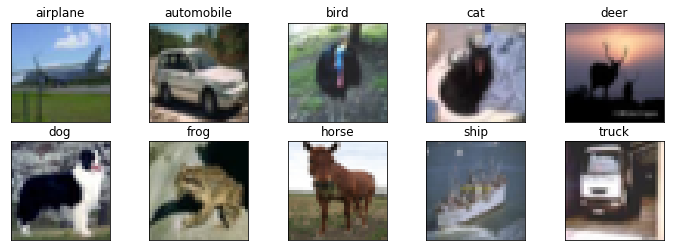

In [8]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(12,4))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

### Now here we are going to create a function which is going to plot our train and test model accuracy and losses with respect epochs.

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

### Also, here we have created one more function which is going to give us actual  test accuracy from model and test data:

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

### Now, lets scale the test and train data and change labels from 1-dimentional class matrix to 10 dimentional class matrix so that we can predict out of 10 class.

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

### In the below model we have used batch normalization and learning rate optimization technique and we have also changed the amount of droupout in each layer. Now, let's see how this model is going to perform:

In [12]:
# Define the model
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu', name='conv2d_1st_layer', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Convolution2D(64, 3, 3, border_mode='same', name='conv2d_2nd_layer', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Convolution2D(128, 3, 3, border_mode='same', name='conv2d_3rd_layer', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))


model.add(Convolution2D(32, 1, 1, activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 

model.add(Convolution2D(32, 3, 3, border_mode='same', name='conv2d_4th_layer', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Convolution2D(64, 3, 3, border_mode='same', name='conv2d_5th_layer', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Convolution2D(128, 3, 3, border_mode='same', name='conv2d_6th_layer', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))


model.add(Convolution2D(32, 1, 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, 3, 3, border_mode='same', name='conv2d_7th_layer', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Convolution2D(64, 3, 3, border_mode='same', name='conv2d_8th_layer', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu', name='conv2d_9th_layer'))
model.add(BatchNormalization())
model.add(Dropout(0.15))


model.add(Convolution2D(10, 1, 1, activation='relu'))
model.add(Convolution2D(10, 8))
model.add(Flatten())
model.add(Activation('softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


W0625 17:40:50.557994 140646436521856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", name="conv2d_1st_layer", input_shape=(32, 32, 3..., padding="same")`
  
W0625 17:40:50.598340 140646436521856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0625 17:40:50.604938 140646436521856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0625 17:40:50.642416 140646436521856 deprecation_

### Now let's look at the model summary, Here we can see we have total of 315K parameters to train. Now let's see how this model is going to perform

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1st_layer (Conv2D)    (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2nd_layer (Conv2D)    (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3rd_layer (Conv2D)    (None, 32, 32, 128)       73856     
__________

### Now we are going to run this model for 100 epochs and let's check what training accuracy we are going to get:

In [0]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint

def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.003), metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_s

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '



Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
97/97 [==============================] - 31s 321ms/step - loss: 1.6971 - acc: 0.3803 - val_loss: 1.6303 - val_acc: 0.4391

Epoch 00001: val_acc improved from -inf to 0.43910, saving model to best_model.hdf5
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
97/97 [==============================] - 25s 260ms/step - loss: 1.2357 - acc: 0.5519 - val_loss: 1.4520 - val_acc: 0.5215

Epoch 00002: val_acc improved from 0.43910 to 0.52150, saving model to best_model.hdf5
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
97/97 [==============================] - 23s 241ms/step - loss: 0.9970 - acc: 0.6435 - val_loss: 1.0962 - val_acc: 0.6235

Epoch 00003: val_acc improved from 0.52150 to 0.62350, saving model to best_model.hdf5
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
97/97 [==============================] - 23s

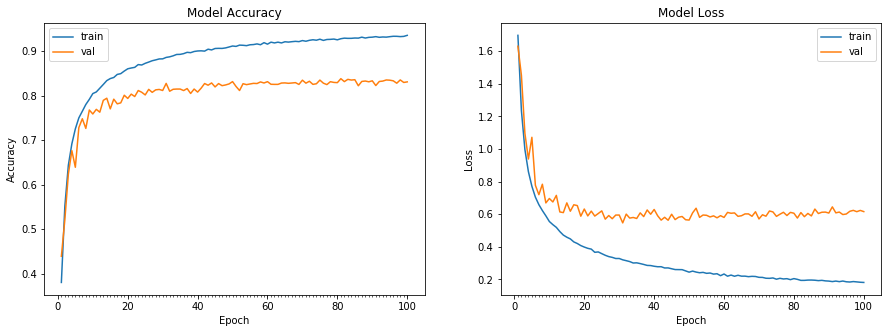

Accuracy on test data is: 83.80


In [15]:
# checkpoint
filepath="best_model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

from keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(zoom_range=0.0,horizontal_flip=False,
                             featurewise_center=True, featurewise_std_normalization=True)

datagen_test = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
iterator_test = datagen_test.flow(test_features, test_labels, batch_size=len(test_features), shuffle=False)
test_features_2, test_labels_2 = iterator_test.next()

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen_train.flow(train_features, train_labels, batch_size = 512),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features_2, test_labels_2), verbose=1,
                                 callbacks=[checkpoint,LearningRateScheduler(scheduler, verbose=1)])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
model.load_weights('best_model.hdf5')
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

### Now lets see the whats the best model accuracy:

In [16]:
model.load_weights('best_model.hdf5')
score = model.evaluate(test_features, test_labels, verbose=0)
y_pred = model.predict(test_features)
print(score)

[0.5759640010595322, 0.838]


### So, from the above we can see that best model validation accuracy is 83.8. Now lets try to find the some misclassified image on top of which we would like to apply gradCAM technique.

In [0]:
# getting index of all misclasified images
img_index = []
for i in range(1,test_features.shape[0]):
  if np.argmax(y_pred[i])!=np.argmax(test_labels[i]):
    img_index.append(i)

### Now let's create some function for gradCAM

In [0]:
def image_reconstract(x):
  # normalize tensor: center on 0., ensure std is 0.1
  x -= x.mean()
  x /= (x.std() + 1e-5)
  x *= 0.1

  # clip to [0, 1]
  x += 0.5
  x = np.clip(x, 0, 1)

  # convert to RGB array
  x *= 255
  #x = x.transpose((1, 2, 0))
  x = np.clip(x, 0, 255).astype('uint8')
  return x
  
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA): 
  # initialize the dimensions of the image to be resized and
  # grab the image size
  dim = None
  (h, w) = image.shape[:2]

  # if both the width and height are None, then return the
  # original image
  if width is None and height is None:
      return image

  # check to see if the width is None
  if width is None:
      # calculate the ratio of the height and construct the
      # dimensions
      r = height / float(h)
      dim = (int(w * r), height)

  # otherwise, the height is None
  else:
      # calculate the ratio of the width and construct the
      # dimensions
      r = width / float(w)
      dim = (width, int(h * r))

  # resize the image
  resized = cv2.resize(image, dim, interpolation = inter)

  # return the resized image
  return resized
  
def applygradCAM(image):
  # expanding dimension for prediction
  x = np.expand_dims(image, axis=0)
  
  # prediction of the image
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  
  # Getting the output of the last convolutional layer 
  last_conv_layer = model.get_layer("conv2d_9th_layer")
  
  # Claculating the gradients
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(128):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  # Creating the heatmap
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap) 
  
  # Resize heatmap to original image size
  heatmap = cv2.resize(heatmap, (x.shape[1], x.shape[2]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  
  # Creating the superimposed Image
  superimposed_img = cv2.addWeighted(image_reconstract(image), 0.6, heatmap, 0.4, 0)
  return superimposed_img  

### Now lets apply gradCAM on top of misclassified image:

In [19]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(12,4))

img_actual = [] 
img_gradCam = [] 
img_actual_value = []
img_pred_value = []
for i in range(1,6):
    img_req = np.array(test_features[img_index[i-1]]).astype(np.float64)
    img_req = image_reconstract(img_req)
    img_actual.append(img_req)
    img_req_grad = applygradCAM(test_features[img_index[i-1]])
    img_gradCam.append(img_req_grad)
    img_actual_value.append(class_names[np.argmax(test_labels[img_index[i-1]])])
    img_pred_value.append(class_names[np.argmax(y_pred[img_index[i-1]])])
      

<Figure size 864x288 with 0 Axes>

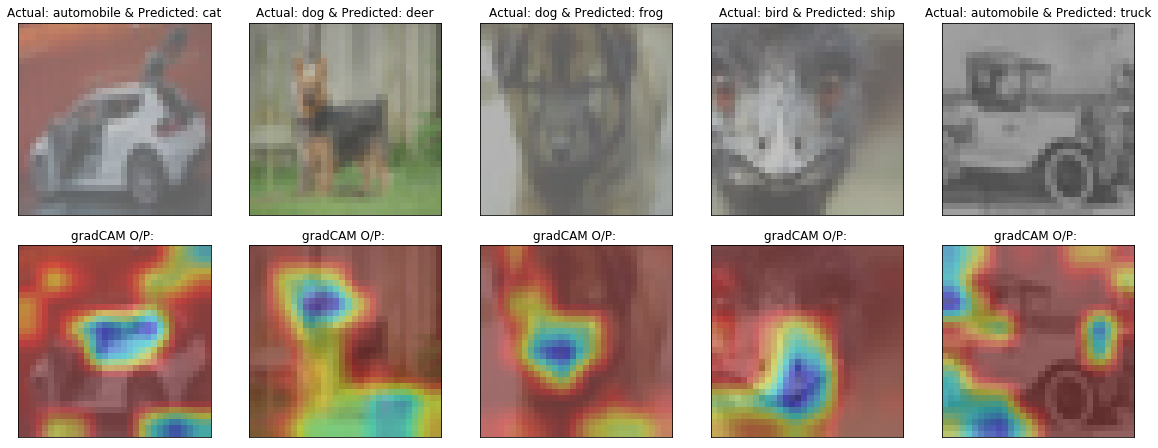

In [20]:
row = 2
col = 5
fig=plt.figure(figsize=(20,15))
for i in range(0,col):
  fig.add_subplot(1,col,i+1)
  plt.imshow(img_actual[i]) 
  plt.title('Actual: '+str(img_actual_value[i])+' & Predicted: '+str(img_pred_value[i]))
  plt.xticks([])
  plt.yticks([])
  fig.add_subplot(2,col,i+6)
  plt.imshow(img_gradCam[i])  
  plt.title('gradCAM O/P: ')
  plt.xticks([])
  plt.yticks([])
plt.show() 




### Now, as we have completed out 1st objetive of implementing gradCAM on top misclassified image. Now we are going to train our model with cutout augmentation and we will check gradCAM output for the above images again.

### So, lets implement cutout augmentation technique in our CFIAR10 dataset and train the model again with augmented data:

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

### Let's create the same model again to compile and run it with cutout Augmentation:

In [22]:
# Define the model
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu', name='conv2d_1st_layer', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Convolution2D(64, 3, 3, border_mode='same', name='conv2d_2nd_layer', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Convolution2D(128, 3, 3, border_mode='same', name='conv2d_3rd_layer', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))


model.add(Convolution2D(32, 1, 1, activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 

model.add(Convolution2D(32, 3, 3, border_mode='same', name='conv2d_4th_layer', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Convolution2D(64, 3, 3, border_mode='same', name='conv2d_5th_layer', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Convolution2D(128, 3, 3, border_mode='same', name='conv2d_6th_layer', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))


model.add(Convolution2D(32, 1, 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, 3, 3, border_mode='same', name='conv2d_7th_layer', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Convolution2D(64, 3, 3, border_mode='same', name='conv2d_8th_layer', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu', name='conv2d_9th_layer'))
model.add(BatchNormalization())
model.add(Dropout(0.15))


model.add(Convolution2D(10, 1, 1, activation='relu'))
model.add(Convolution2D(10, 8))
model.add(Flatten())
model.add(Activation('softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", name="conv2d_1st_layer", input_shape=(32, 32, 3..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), name="conv2d_2nd_layer", activation="relu", padding="same")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), name="conv2d_3rd_layer", activation="relu", padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), activation="relu")`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), name="conv2d_4th_layer

In [0]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint

def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.003), metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_s

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '



Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
97/97 [==============================] - 27s 277ms/step - loss: 1.7661 - acc: 0.3547 - val_loss: 1.5981 - val_acc: 0.4521

Epoch 00001: val_acc improved from -inf to 0.45210, saving model to best_model.hdf5
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
97/97 [==============================] - 24s 242ms/step - loss: 1.3408 - acc: 0.5067 - val_loss: 1.6889 - val_acc: 0.4740

Epoch 00002: val_acc improved from 0.45210 to 0.47400, saving model to best_model.hdf5
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
97/97 [==============================] - 23s 241ms/step - loss: 1.1220 - acc: 0.5952 - val_loss: 1.1523 - val_acc: 0.6170

Epoch 00003: val_acc improved from 0.47400 to 0.61700, saving model to best_model.hdf5
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
97/97 [==============================] - 23s

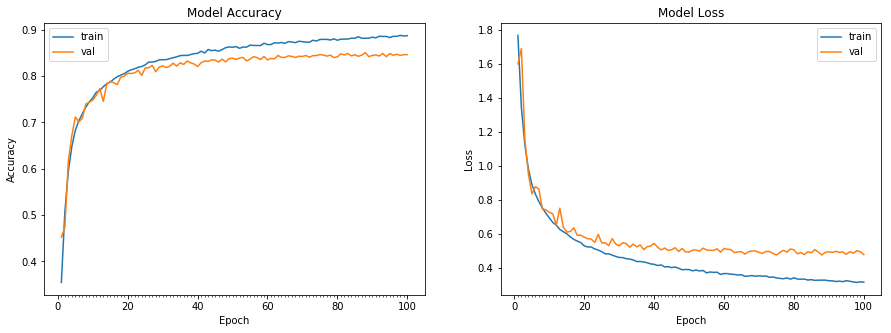

Accuracy on test data is: 85.09


In [24]:
# checkpoint
filepath="best_model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

from keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(zoom_range=0.0,horizontal_flip=False,
                             featurewise_center=True, featurewise_std_normalization=True,preprocessing_function=get_random_eraser(v_l=0, v_h=1,pixel_level=True))

datagen_test = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
iterator_test = datagen_test.flow(test_features, test_labels, batch_size=len(test_features), shuffle=False)
test_features_2, test_labels_2 = iterator_test.next()

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen_train.flow(train_features, train_labels, batch_size = 512),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features_2, test_labels_2), verbose=1,
                                 callbacks=[checkpoint,LearningRateScheduler(scheduler, verbose=1)])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
model.load_weights('best_model.hdf5')
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

### So in the above model with cutout augmentation we can see that we got a validation accuracy of 85.09 with the same model which is better than our previous validation accuracy 83.8. We have achieved this increased accuracy just by introducing cutout augmentation.
### Now let's plot the same images as above and let's check theit gradCAM output again with the updated model details:

In [25]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(12,4))

img_actual = [] 
img_gradCam = [] 
img_actual_value = []
img_pred_value = []
for i in range(1,6):
    img_req = np.array(test_features[img_index[i-1]]).astype(np.float64)
    img_req = image_reconstract(img_req)
    img_actual.append(img_req)
    img_req_grad = applygradCAM(test_features[img_index[i-1]])
    img_gradCam.append(img_req_grad)
    img_actual_value.append(class_names[np.argmax(test_labels[img_index[i-1]])])
    img_pred_value.append(class_names[np.argmax(y_pred[img_index[i-1]])])

<Figure size 864x288 with 0 Axes>

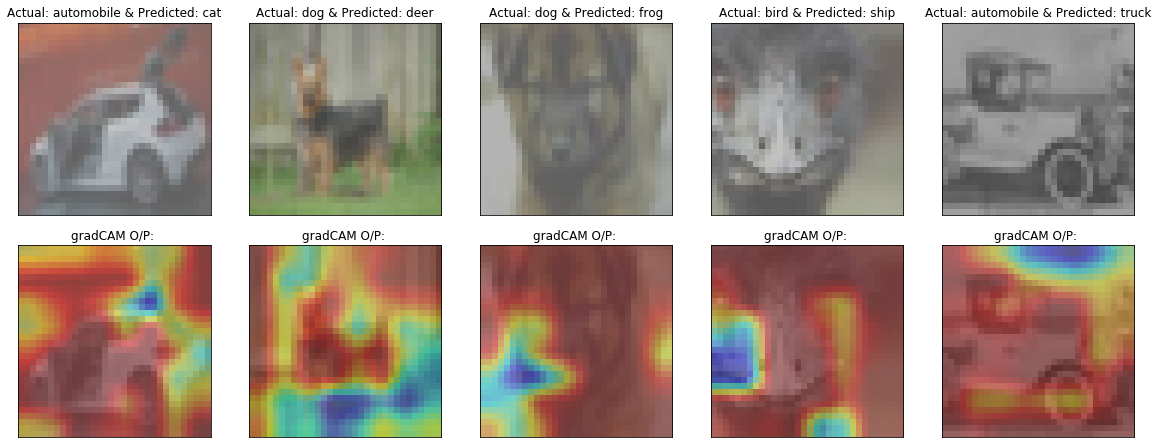

In [26]:
row = 2
col = 5
fig=plt.figure(figsize=(20,15))
for i in range(0,col):
  fig.add_subplot(1,col,i+1)
  plt.imshow(img_actual[i]) 
  plt.title('Actual: '+str(img_actual_value[i])+' & Predicted: '+str(img_pred_value[i]))
  plt.xticks([])
  plt.yticks([])
  fig.add_subplot(2,col,i+6)
  plt.imshow(img_gradCam[i])  
  plt.title('gradCAM O/P: ')
  plt.xticks([])
  plt.yticks([])
plt.show() 

### So from the above we can see after re-training model again gradCAM output got changed from previous.